In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# scaling/preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression #model_1
from sklearn.neighbors import KNeighborsClassifier #model_2
from sklearn.tree import DecisionTreeClassifier, plot_tree #model_3
from xgboost import XGBClassifier #model_4
from lightgbm import LGBMClassifier #model_5
from sklearn.ensemble import RandomForestClassifier # successful model

# metrics
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from warnings import simplefilter
simplefilter("ignore")

## Scaling

In [11]:
df = pd.read_csv('training.csv')
X = df.drop(columns='Bankrupt?')
y = df['Bankrupt?']


#scale data between -1 to 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Capping outliers

In [12]:
def outlier_imputer(data,features):
    data_out = data.copy()
    for column in features:
        Q1 = data_out[column].quantile(0.25)
        Q3 = data_out[column].quantile(0.75)
        IQR = Q3 - Q1
        lowerL = (Q1 - 1.5 * IQR)
        higherL = (Q3 + 1.5 * IQR)

        data_out.loc[data_out[column] < lowerL,column] = lowerL
        data_out.loc[data_out[column] > higherL,column] = higherL

    return data_out

data_in    = X.select_dtypes(include='float')
features_in = data_in.columns

capped_data = outlier_imputer(data_in,features_in)
data_int = X.select_dtypes(include='int')

X = pd.concat([capped_data,data_int],axis=1)

## Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SMOTE with custom class ratios

In [14]:
def resampled(X_train,y_train,r):
  smote = SMOTE(sampling_strategy=r)

  X_overSampled,y_overSampled = smote.fit_resample(X_train,y_train)
  return X_overSampled,y_overSampled

#best ratio found was 10%
X_train, y_train = resampled(X_train,y_train,0.1)

## Relative Feature Importance to select features

In [15]:
random_forest = RandomForestClassifier(random_state=1,max_depth=4)
random_forest.fit(X_train,y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

importances

,feature,importance
18,Persistent EPS in the Last Four Seasons,0.090
29,Net Value Growth Rate,0.075
22,Per Share Net profit before tax (Yuan ¥),0.063
42,Net profit before tax/Paid-in capital,0.046
84,Net Income to Total Assets,0.039
...,...,...
70,Current Asset Turnover Rate,0.001
3,Operating Gross Margin,0.000
87,Gross Profit to Sales,0.000
93,Liability-Assets Flag,0.000


In [16]:
importances = importances[importances['importance'] > 0.02]
list_features = importances['feature'].to_list()

list_features

[' Persistent EPS in the Last Four Seasons',
 ' Net Value Growth Rate',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Net profit before tax/Paid-in capital',
 ' Net Income to Total Assets',
 ' Net worth/Assets',
 ' Debt ratio %',
 " Net Income to Stockholder's Equity",
 ' Net Value Per Share (B)',
 ' Borrowing dependency',
 ' Non-industry income and expenditure/revenue',
 ' After-tax net Interest Rate',
 ' Net Value Per Share (C)',
 ' ROA(B) before interest and depreciation after tax',
 ' Total debt/Total net worth',
 ' Liability to Equity']

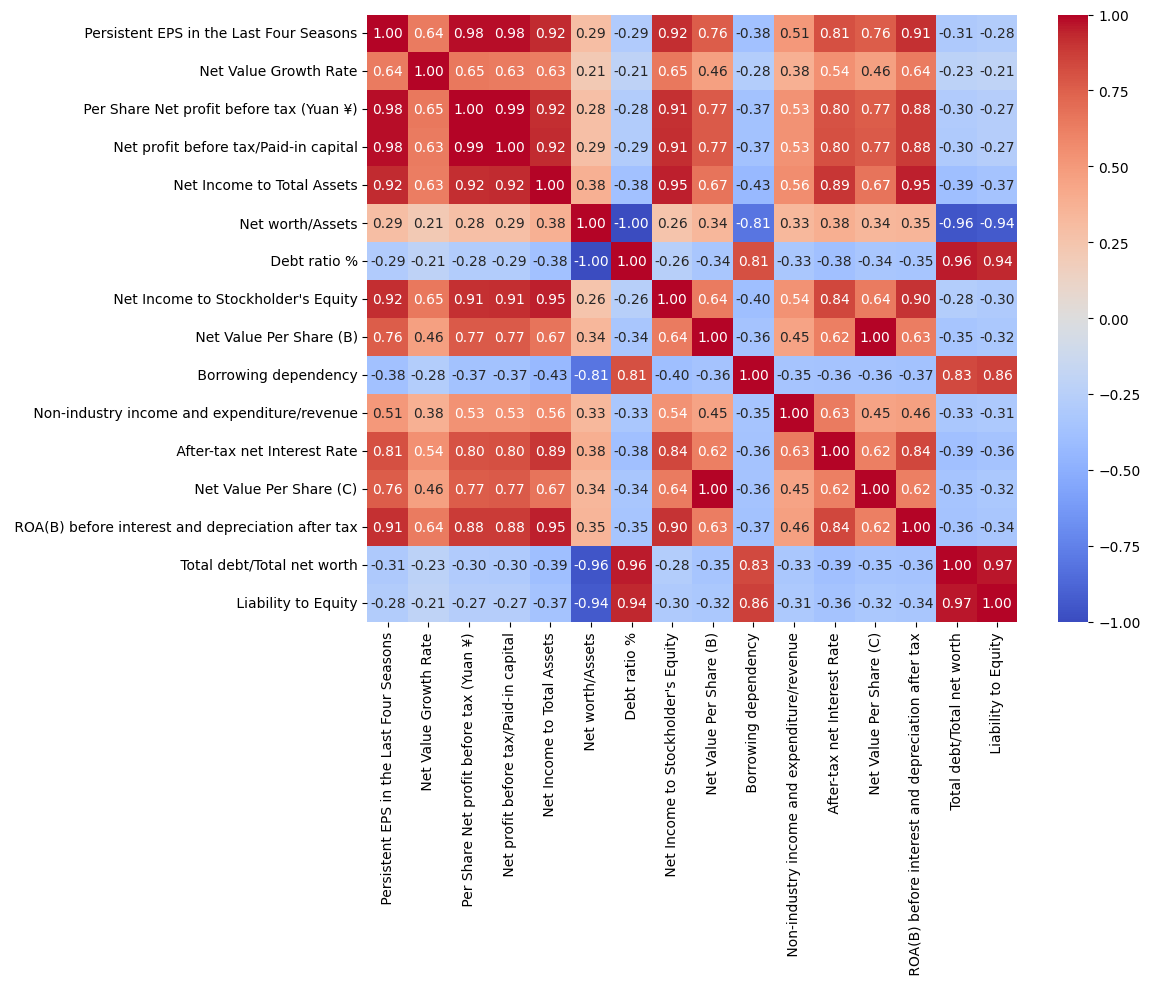

In [17]:
plt.figure(figsize = (12,10))
sns.heatmap(X_train[list_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.tight_layout(); plt.show()

## Removing some features based on correlation

In [18]:
list_remove = [' ROA(A) before interest and % after tax',
               ' ROA(C) before interest and depreciation before interest',
               ' Per Share Net profit before tax (Yuan ¥)',
               ' Net profit before tax/Paid-in capital',
               ' Debt ratio %',
               ' Liability to Equity']
list_features = list(set(list_features) - set(list_remove))

X_train = X_train[list_features]
X_test = X_test[list_features]

## Final Data used to train subsequent models:

In [19]:
print(X_train.shape)
print("-"*30)
print(y_train.value_counts())
print("-"*30)
X_train.head()


(4667, 12)
------------------------------
Bankrupt?
0    4243
1     424
Name: count, dtype: int64
------------------------------


,Net Income to Total Assets,Net Value Per Share (B),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Net Value Growth Rate,Net worth/Assets,Net Income to Stockholder's Equity,Non-industry income and expenditure/revenue,After-tax net Interest Rate,ROA(B) before interest and depreciation after tax,Total debt/Total net worth,Borrowing dependency
0,0.793573,0.206565,0.206565,0.212820,0.000426,0.900989,0.839875,0.303509,0.809306,0.518871,0.004608,0.373907
1,0.808235,0.196452,0.196452,0.230217,0.000439,0.849956,0.841193,0.303527,0.809347,0.541624,0.009391,0.371295
2,0.798052,0.242699,0.242689,0.219533,0.000440,0.851014,0.840236,0.303459,0.809316,0.528294,0.009258,0.376631
3,0.869981,0.196578,0.196578,0.261984,0.000488,0.937207,0.844409,0.303524,0.809545,0.667862,0.002471,0.369637
4,0.827444,0.176520,0.176520,0.229649,0.000479,0.926082,0.841991,0.303542,0.809498,0.576423,0.003054,0.370409


# FAILED METHODS


Logistic Regression

In [20]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
y_predicted = model_1.predict(X_test)

print("Classification Report:")
print("")
print(classification_report(y_test,y_predicted))

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1058
           1       0.33      0.12      0.18        33

    accuracy                           0.97      1091
   macro avg       0.65      0.56      0.58      1091
weighted avg       0.95      0.97      0.96      1091



KNN Classifier

In [21]:
model_2 = KNeighborsClassifier()
model_2.fit(X_train, y_train)
y_predicted = model_2.predict(X_test)

print("Classification Report:")
print("")
print(classification_report(y_test,y_predicted))

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1058
           1       0.29      0.42      0.35        33

    accuracy                           0.95      1091
   macro avg       0.64      0.70      0.66      1091
weighted avg       0.96      0.95      0.96      1091



Decision Tree Classifier

In [23]:
model_3 = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
model_3.fit(X_train, y_train)
y_predicted = model_3.predict(X_test)

print("Classification Report:")
print("")
print(classification_report(y_test,y_predicted))

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1058
           1       0.25      0.52      0.34        33

    accuracy                           0.94      1091
   macro avg       0.62      0.73      0.65      1091
weighted avg       0.96      0.94      0.95      1091



XGBoost with Cross Validation

In [28]:
model_4 = XGBClassifier()

# 7 fold cross validation
cv_scores = cross_val_score(model_4, X_train, y_train, cv=7, scoring='accuracy')
print("Cross-Validation Accuracies :", cv_scores.round(3))
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

model_4.fit(X_train, y_train)
y_predicted = model_4.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_predicted))

Cross-Validation Accuracies : [0.934 0.943 0.973 0.975 0.963 0.973 0.962]
Mean Cross-Validation Accuracy: 0.9603631260302924

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1058
           1       0.26      0.24      0.25        33

    accuracy                           0.96      1091
   macro avg       0.62      0.61      0.61      1091
weighted avg       0.95      0.96      0.96      1091



LGBM with cross validation\
(Light Gradient Boosting Machine Classifier)

In [37]:
model_5 = LGBMClassifier(boosting_type='gbdt', force_col_wise=True, verbosity=-1)


# 7 fold cross validation
cv_scores = cross_val_score(model_5, X_train, y_train, cv=7, scoring='accuracy')
print("Cross-Validation Accuracies :", cv_scores.round(3))
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

model_5.fit(X_train, y_train)
y_predicted = model_5.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_predicted))

Cross-Validation Accuracies : [0.939 0.937 0.973 0.969 0.972 0.967 0.961]
Mean Cross-Validation Accuracy: 0.9595048035827646

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1058
           1       0.34      0.33      0.34        33

    accuracy                           0.96      1091
   macro avg       0.66      0.66      0.66      1091
weighted avg       0.96      0.96      0.96      1091



Neural Network\
(didn't expect this to work anyways, but here is the proof:)

In [41]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(640, activation='relu'),
    keras.layers.Dense(320, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred = (model.predict(X_test) > 0.5).astype(int)
print("-"*100)
print(classification_report(y_test, y_predicted))

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9057 - loss: 0.3355 - val_accuracy: 0.9698 - val_loss: 0.1475
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9105 - loss: 0.2649 - val_accuracy: 0.9698 - val_loss: 0.1146
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9175 - loss: 0.1959 - val_accuracy: 0.9615 - val_loss: 0.1054
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9288 - loss: 0.1745 - val_accuracy: 0.9478 - val_loss: 0.1213
Epoch 5/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9240 - loss: 0.1738 - val_accuracy: 0.9533 - val_loss: 0.1115
Epoch 6/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9282 - loss: 0.1691 - val_accuracy: 0.9441 - val_loss: 0.1230
Epoch 7/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9230 - loss: 0.1699 - val_accuracy: 0.9514 - val_loss: 0.1077
Epoch 8/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9254 - loss: 0.1768 - val_accuracy: 0.

# Random forest (SUCCESSFUL)

In [38]:
random_forest = RandomForestClassifier(class_weight='balanced')

random_forest.fit(X_train,y_train)
rf_train_preds = random_forest.predict(X_train)

rf_train_results = classification_report(rf_train_preds,y_train)
print(rf_train_results)

rf_test_preds = random_forest.predict(X_test)

rf_test_over_results = classification_report(rf_test_preds,y_test)
print(rf_test_over_results)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4242
           1       1.00      1.00      1.00       425

    accuracy                           1.00      4667
   macro avg       1.00      1.00      1.00      4667
weighted avg       1.00      1.00      1.00      4667

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1072
           1       0.21      0.37      0.27        19

    accuracy                           0.97      1091
   macro avg       0.60      0.67      0.63      1091
weighted avg       0.98      0.97      0.97      1091



##Things left to do:
- for each model, tune hyperparameters also, for example XGB mein the hyperparams can be tuned maybe can show with grid search to optimize
- show with grid search that:
  - features with importance >0.02 should be taken
  - SMOTE should be performed with 10% class ratio
  - XGB and other models hyperparameters are optimized
  - we still chose RF because of following reasons: (grid search)


https://www.kaggle.com/code/semihgnak/bankruptcy-perdiction-pca-smote-99-f1-score

https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fcode%2Fjacopoferretti%2Fcompany-bankruptcy-classif-w-feature-selection


# Evaluation


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set paths
test_data_dir = "/home/data/test"  # Change this to your test folder path
image_size = (256, 256)
batch_size = 32
num_classes = 6  # Total number of classes

# Load the trained model
model = load_model("cnn_model.h5")

# Print the model summary
print("\nModel Summary:")
model.summary()

# Load test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Keep order for confusion matrix
)

# Get true labels and class names
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Get predictions
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average="weighted")
recall = recall_score(true_labels, pred_labels, average="weighted")
f1 = f1_score(true_labels, pred_labels, average="weighted")

# Print evaluation metrics
print(f"\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
